In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 4.1 MB/s 
     |████████████████████████████████| 948 kB 26.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=e4a6535ffd1bfc9dfb7c43657ef3e9fcc27d44adc19155e94fd38bafe5d2d160
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [336]:
import pandas as pd
import torchvision.models as models
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import seaborn as sns
import torchvision
import torch
import torchvision.transforms as transforms
import warnings
import numpy as np
import torchvision.ops as Ops
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import cv2
import pandas as pd
import seaborn as sns
import spacy
from tqdm import tqdm
import albumentations as A
import random
import numpy as np
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/MyDrive/CS6140Dataset/'

Mounted at /content/drive


In [ ]:
          !cat /content/drive/MyDrive/CS6140Dataset/dataset/


cat: /content/drive/MyDrive/CS6140Dataset/dataset/: Is a directory


Data Gathering

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS6140Dataset/dataset/dataset_list.csv')

df = df.sample(frac=1)
train_ = df.sample(frac=0.6)
rest = df.drop(train_.index,axis=0).sample(frac=0.5)
val_ = rest.iloc[:rest.shape[0]//2,:]
test_ = rest.iloc[rest.shape[0]//2:,:]

train_.to_csv('/content/drive/MyDrive/CS6140Dataset/dataset/train_list.csv', index=False)
val_.to_csv('/content/drive/MyDrive/CS6140Dataset/dataset/val_list.csv', index=False)
test_.to_csv('/content/drive/MyDrive/CS6140Dataset/dataset/test_list.csv', index=False)

In [ ]:
def init_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
      m.bias.data.fill_(0.01)
    

Model Implementation - Unet, ResNet

In [ ]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
                        nn.Conv2d(in_ch, out_ch, 3,1,1, bias=False),
                        nn.BatchNorm2d(out_ch),
                        nn.ReLU(inplace = True),
                        nn.Conv2d(out_ch, out_ch, 3,1,1, bias=False),
                        nn.BatchNorm2d(out_ch),
                        nn.ReLU(inplace = True),
                    )
    def forward(self, x):
        return self.conv(x)

In [318]:
class UNET(nn.Module):
    
    def __init__(self, in_ch = 3, out_ch = 1, features=[32,64,128,256]):
        super().__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #Down
        for feature in features:
            self.down.append(DoubleConv(in_ch, feature))
            in_ch = feature
            
        #up
        for feature in reversed(features):
            self.up.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size = 2, stride = 2 )
            )
            self.up.append(DoubleConv(feature*2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_ch, kernel_size = 1)
        
    def forward(self, x):
        skip_connection = []
        for down in self.down:
            x = down(x)
            skip_connection.append(x) 
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connection = skip_connection[::-1]
        
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip_con = skip_connection[idx//2]
            if x.shape != skip_con.shape:
                x = TF.resize(x,size = skip_con.shape[2:])
            concatenate_skip = torch.cat((skip_con,x), dim = 1)
            x =self.up[idx+1](concatenate_skip)
        
        return self.final_conv(x)

In [ ]:
def test():
    x = torch.rand((3,3,161,161))
    model = UNET(in_ch = 3, out_ch = 1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)

In [ ]:
class ResNetUnit(nn.Module):
    def __init__(self, in_channels, out_channels, downsample = False):
      super().__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      if downsample:
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=2, padding=1, bias = False)
        self.shortcut = nn.Sequential(
                          nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=2,  bias = False),
                          nn.BatchNorm2d(out_channels)
                          )
      else:
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride=1, padding="same", bias = False)
        self.shortcut = lambda x:x
      
      self.batchN1  = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride=1, padding="same", bias = False)
      self.batchN2  = nn.BatchNorm2d(out_channels)
      
      self.relu = nn.ReLU()
  

    def forward(self, x):
      identity = self.shortcut(x)
      x = self.relu(self.batchN1(self.conv1(x)))
      x = self.batchN2(self.conv2(x))
      x += identity
      return self.relu(x)

class ResNet(nn.Module):
  def __init__(self, in_channel, out_channels, num_layers): #num_layers = [64, 128, 256,512]
    super().__init__()
    if len(num_layers) != 3:
      raise Exception('Not a valid architecture')
    self.init_layer = nn.Sequential(
          nn.Conv2d(in_channel, 64, kernel_size = 7 , stride = 2,  padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    )
    #Conv Layer
    #1 - 64in 64 out
    self.layers64 = self.build_Conv_layers(64, 64, num_layers[0])
    #2 - 64in 128 out
    self.layers128 = self.build_Conv_layers(128, 128, num_layers[1])
    #3 - 128 in 256 out
    self.layers256 = self.build_Conv_layers(256, 256, num_layers[2])
    #4 - 256 in 512 out
    #self.layers512 = self.build_Conv_layers(512, 512, num_layers[3])
    # [Batch x 1024 x 4 x 4]
    #self.avgpool = nn.AdaptiveAvgPool2d((4,4))
    #Deconv Layers
    # [Batch x 1024 x 4 x 4] - [Batch x 256 x 16 x 16]
    #self.deConv16 = self.build_DeConv_layers(1024, 256, 2)
    self.deConv32 = self.build_DeConv_layers(512, 256, 2)
    #[Batch x 256 x 16 x 16]- [Batch x 128 x 64 x 64]
    #self.deConv64 = self.build_DeConv_layers(256, 128, 2)
    self.deConv128 = self.build_DeConv_layers(256, 128, 2)
    #[Batch x 128 x 64 x 64] - [Batch x 64 x 256 x 256]
    self.deConv256 = self.build_DeConv_layers(128, 64, 2, kernel_size = 2, stride = 2)

    #[Batch x 64 x 1 x 62564]
    self.fc = nn.Conv2d(64, out_channels, kernel_size = 3, stride=1, padding="same", bias = False)
  
  def build_Conv_layers(self,in_channel,out_channel, num_layers):
    layers = []
    for each in range(num_layers - 1):
      layers.append(ResNetUnit(out_channel, out_channel))
    layers.append(ResNetUnit(out_channel, out_channel*2, downsample = True))
    return nn.Sequential(*layers)
  
  def build_DeConv_layers(self,in_channel,out_channel, num_layers, kernel_size = 4, stride = 4):
    layers = [ nn.ConvTranspose2d(in_channel, out_channel , kernel_size = kernel_size, stride = stride )]
    for each in range(num_layers - 1):
      layers.append(ResNetUnit(out_channel, out_channel))
    layers.append(ResNetUnit(out_channel, out_channel))
    return nn.Sequential(*layers)
  

  def forward(self, x):
    x = self.init_layer(x)
    #conv
    x = self.layers64(x)    
    x = self.layers128(x)
    x = self.layers256(x)
    #x = self.layers512(x)
    
    #deconv
    x = self.deConv32(x)
    #x = self.deConv16(x)
    x = self.deConv128(x)
    #x = self.deConv64(x)
    x = self.deConv256(x)
    return F.sigmoid(self.fc(x))

In [ ]:
class EmptyLayer(nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self,x):
    return x

class BasicBlockUpdated(nn.Module):
  def __init__(self, in_channels, out_channels, downsample = False):
      super().__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      self.bn1 =  nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      self.relu = nn.ReLU(inplace=True)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      self.bn2 =  nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    
  def forward(self, x):
    identity = x
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    x += identity
    return self.relu(x)

class ResNetUpdated(nn.Module):
  def __init__(self, in_channel, out_channels, model): #num_layers = [64, 128, 256,512]
    super().__init__()
    self.resnetmodel = model
    
    self.deConv16 = self.build_DeConv_layers(512, 256, 2)
    #                  self.build_DeConv_layers(512, 256, 2),
    #[Batch x 256 x 16 x 16]- [Batch x 128 x 64 x 64]
    self.deConv64 = self.build_DeConv_layers(256, 128, 2)
    #                 self.build_DeConv_layers(256, 128, 2),
    #[Batch x 128 x 64 x 64] - [Batch x 64 x 256 x 256]
    #                  self.build_DeConv_layers(128, 64, 2, kernel_size = 2, stride = 2)
    self.deConv256 = self.build_DeConv_layers(128, 64, 2, kernel_size = 2, stride = 2)
    #[Batch x 64 x 1 x 62564]
    self.resnetmodel.avgpool = EmptyLayer()
    self.fc = nn.Conv2d(64, out_channels, kernel_size = 3, stride=1, padding="same", bias = False)
    self.resnetmodel.fc = EmptyLayer()
    self.relu = nn.ReLU()

  def build_DeConv_layers(self,in_channel,out_channel, num_layers, kernel_size = 4, stride = 4):
    
    layers = [ nn.ConvTranspose2d(in_channel, out_channel , kernel_size = kernel_size, stride = stride )]
    for each in range(num_layers - 1):
      layers.append(BasicBlockUpdated(out_channel, out_channel))
    layers.append(BasicBlockUpdated(out_channel, out_channel))
    return nn.Sequential(*layers)
  

  def forward(self, x):
    x = self.resnetmodel(x).reshape(x.shape[0], 512,8,8)
    #print(x.shape)
    x = self.deConv16(x)
    x = self.deConv64(x)
    x = self.deConv256(x)
    x = self.fc(x)
    return F.sigmoid(x)

In [ ]:
x = torch.randn(64,3,256,256)
net = ResNet(3,1,[3,4,8])
net(x).shape

Defning Dataset class

In [369]:
def crop(img, size=128):
    c1,c2 = img.shape[0] // 2, img.shape[1] // 2
    return img[ c1 -size : c1 + size , c2-size : c2 + size ]

A_trans_both = A.Compose([
     A.ShiftScaleRotate( p=0.25, border_mode= cv2.BORDER_CONSTANT),
     A.Flip(p=0.4),
     A.RandomCrop(height=256, width=256, p=0.3) 
])
A_trans_img = A.Compose([
    A.OneOf([
             A.GaussianBlur(p=0.1),
             A.GaussNoise(p=0.9),
             ], p =0.25),
])

transform_img = transforms.Compose([
                                
                                transforms.ToTensor(),
                                transforms.Resize((256,256)),
                                #transforms.CenterCrop(256),
                                transforms.ColorJitter( contrast=(25)),
                                transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5]),
                                transforms.Grayscale()
                                ])

transform_msk = transforms.Compose([
                                
                              transforms.ToTensor(),
                               transforms.Resize((256,256)),
                                #transforms.CenterCrop(256),
                                ])

class NucleusDataset(Dataset):
    
    def __init__(self, root_dir, type_, transform=None):
        self.root_dir = root_dir
        self.type_ = type_
        self.transform = transform
        self.dataset = pd.read_csv(f'{root_dir}/dataset/{type_}_list.csv')
        self.X, self.Y = [],[]
        for idx in range(self.dataset.shape[0]):
          img_src = self.dataset.iloc[idx]['img_src']
          msk_src = self.dataset.iloc[idx]['mask_src']
          img = cv2.imread(f'{self.root_dir}/{img_src[1:]}')

          if all( i >=128 for i in img.mean(axis =  (0,1))): 
            self.X.append(255 - img)
          else:
            self.X.append(img)
          
          msk = cv2.imread(f'{self.root_dir}/{msk_src[1:]}',0)
          self.Y.append(msk)
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        img_ = self.X[idx]
        msk_ = self.Y[idx]
        if self.transform:
          a1 = A_trans_both(image=img_, mask = msk_)
          #img_ = a1['image']
          #msk_ = a1['mask']
          #a2 = A_trans_img(image = img_)
          #img_ = a2['image']
          img_ = transform_img(img_)
          msk_ = transform_msk(msk_)
        return img_, msk_

In [370]:
BATCH_SIZE = 16
root_dir = '/content/drive/MyDrive/CS6140Dataset/'
train_data = NucleusDataset(
    root_dir = root_dir,
    type_ = 'train',
    transform = True
    #transform_img = transform_img, transform_msk = transform_msk
    #transform_img = crop, transform_msk = crop
    
)

val_data = NucleusDataset(
    root_dir = root_dir,
    type_ = 'val',
    transform = True,
    #transform_img = transform_img, transform_msk = transform_msk
    #transform_img = crop, transform_msk = crop
)
test_data = NucleusDataset(
    root_dir = root_dir,
    type_ = 'test',
    transform = True
    #transform_img = transform_img, transform_msk = transform_msk
    #transform_img = crop, transform_msk = crop
)


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                    pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True,
                    pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,
                    pin_memory=True)

Data analysis

In [ ]:
imges = torch.empty((0,3,256,256))
i = 0
for img,mask in train_data:

  imges = torch.vstack((imges,img.unsqueeze(0)))
  i+=1
imges.shape

In [ ]:
imges.mean((0,2,3)), imges.std((0,2,3))

(tensor([ 2.8246e-04, -2.7115e-05, -2.2161e-04]),
 tensor([1.0002, 1.0003, 1.0002]))

In [ ]:
norm = transforms.Normalize(mean = [0.0983, 0.1067, 0.1035], std = [0.1555, 0.1590, 0.1494])


By plotting the count of pixel values, it can be seen that there are large number of pixels that belong to the "black" side, or that do not belong to the nucleus region. However, there is a long range of pixel values that may or may not belong to the nucleus region

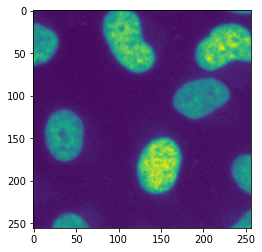

In [ ]:

sample = train_data[0][0].numpy().squeeze()
plt.imshow(sample)

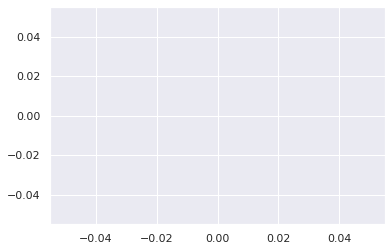

In [352]:
X, Y = torch.unique(imgs,  return_counts=True)
plt.plot(X,Y)

In [ ]:
X,Y1= torch.unique((imgs*255).int().permute(1,0,2,3)[0], return_counts=True)
X,Y2 = torch.unique((imgs*255).int().permute(1,0,2,3)[1], return_counts=True)
X,Y3 = torch.unique((imgs*255).int().permute(1,0,2,3)[2], return_counts=True)
df = pd.DataFrame({ 'RED': Y1,'BLUE':Y3,'GREEN':Y2})

sns.lineplot(data=df, dashes=False, palette=['r', 'b','g'])
plt.xlabel('Pixel')
plt.ylabel('Count')

In [331]:
imgs.shape

torch.Size([402, 3, 256, 256])

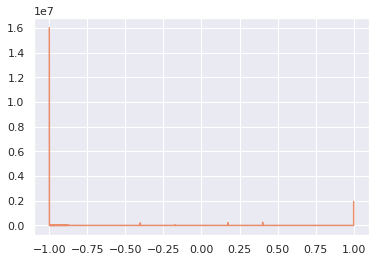

In [372]:
X, Y = torch.unique(imgs,  return_counts=True)
plt.plot(X,Y)

We can apply another transformation to bring in contrast, that can help us get more distinction between nucleus region and non nucleus region

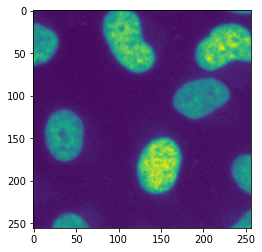

In [ ]:
#sample= transforms.functional.adjust_contrast(train_data[0][0],contrast_factor=60).numpy().squeeze()


Image analysis - contrast transformation:
If we apply a high contrast transformation on the images, we can see that there is a clear distinct line on the train dataset that can divide the nucleus and non nuclues regions. 

In [371]:
imgs = torch.empty(0,1,256,256)
msks = torch.empty(0,1,256,256)
for img,msk in train_dataloader:
  #print(img.shape)
  imgs = torch.concat((imgs, img), dim = 0)
  msks = torch.concat((msks, msk), dim = 0)

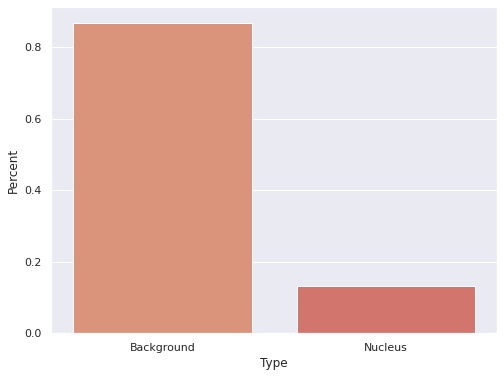

In [328]:
A = (msks.int() == 0).sum()
B = (msks.int() == 1).sum()
A_ = A/(A+B)
B_ = B/(A+B)
sns.set_theme()
plt.figure(figsize=(8, 6))
sns.set_palette(sns.color_palette("flare"))
box = pd.DataFrame({'Percent':[A_.item(),B_.item()], 'Type':['Background','Nucleus']})
splot = sns.barplot(data = box, x = 'Type', y='Percent')

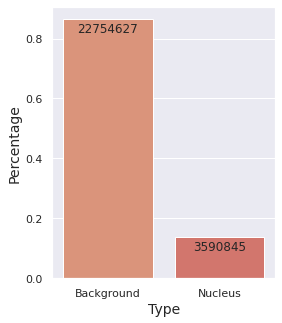

In [ ]:
plt.figure(figsize=(4, 5))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(data = box, x = 'Type', y='Percent')
 
# Iterrating over the bars one-by-one
g = [int(A),int(B)]
for i,p in enumerate(plots.patches):
    plots.annotate(format(g[i]), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -9), 
                   textcoords = 'offset points')
 
# Setting the label for x-axis
plt.xlabel("Type", size=14)
 
# Setting the label for y-axis
plt.ylabel("Percentage", size=14)
 
# Setting the title for the graph

 
# Finally showing the plot
plt.show() 

In [ ]:
g = [A,B]
for i,p in enumerate(splot.patches):
    splot.annotate(format(g[i], '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -9), 
                   textcoords = 'offset points')

sns.show()

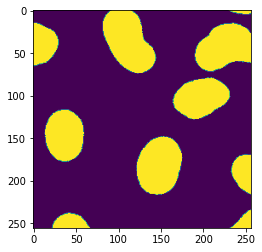

In [ ]:
sample = train_data[0][0].numpy().squeeze()
plt.imshow(sample)

Implementation of IoU metric and different Losses

In [ ]:
def get_iou(A,B, smooth = 1):

    I = torch.logical_and(A.view(-1),B.view(-1)).float().sum()
    U = torch.logical_or(A.view(-1),B.view(-1)).float().sum()
    return (I + smooth)/ (U + smooth)

def get_acc(A,B, smooth = 0.1):
  num = (A == B).sum()
  denum = A.numel()
  return num/denum

def get_IoU(A,B, smooth = 0.1):
  I = torch.logical_and(A,B).sum()
  U = torch.logical_or(A,B).sum()
  return (I+smooth)/(U+smooth)
    
class DiceLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, target,inputs):
        smooth = 1.

        iflat = inputs.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        
        return -torch.log(((2. * intersection + smooth) /
                  (iflat.sum()**2 + tflat.sum()**2 + smooth))).requires_grad_()

class IoULoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, target,inputs):
               
        return  (1 - get_IoU(target,inputs)).requires_grad_()


class DiceBCELoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, inputs, target):
        #loss = super().forward(target,input)
        loss = F.binary_cross_entropy(inputs, target)
        smooth = 1
        I = torch.logical_and(target,inputs).sum() +1
        U = (target**2).sum() + (inputs**2).sum() + 1
        
        return loss + 1 - I/U

class FocalLoss(nn.Module):
    def __init__(self,
                        alpha: float = 0.25,
                        gamma: float = 2,
                        reduction: str = "mean",):
        super().__init__()
        self.alpha = alpha 
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, target):
        #loss = super().forward(target,input)
        p = inputs
        ce_loss = F.binary_cross_entropy(inputs, target, reduction="none")
        p_t = p * target + (1 - p) * (1 - target)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

Evaluation Metric:

The evaluation metric for the segmentation problem can be tricky. To go with the most common one the accuracy score where accuracy of an image j can be given as:
$$
a_j = \frac{T_j \cap G_j}{T_j} 
$$
$$\text{Where }T_j\text{ is the actual mask or label for the image and } G_j \text{ is the predicted labels or mask for the image}$$
However this can be a very biased metric, because in our dataset most of the images have a large black region and through the example below, we can see that even if the model labels all the pixel as zero that is belonging to negative class, we can still get nearly 82% accuracy.

In [ ]:
_ , sample_mask = next(iter(train_dataloader))
shape = sample_mask.shape
get_acc(sample_mask,sample_mask)

tensor(1.)

In [ ]:
_ , sample_mask = next(iter(train_dataloader))
black_image = torch.zeros(sample_mask.shape)
print(black_image.shape)
get_acc(sample_mask,black_image)

torch.Size([128, 1, 256, 256])


tensor(0.8667)

Hence, another popular metric for such problems is to use IoU score, which is Intersection of Union or mean IoU score.
where IoU of an image j can be given as:
$$
a_j = \frac{T_j \cap G_j +\epsilon}{T_j \cup G_j + \epsilon} 
$$
$$\text{Where }T_j\text{ is the actual mask or label for the image and } G_j \text{ is the predicted labels or mask for the image and } \epsilon \text{ is a small smoothening factor to avoid division by zero}$$
This metric is senitive to the Positive class.


In [ ]:
_ , sample_mask = next(iter(train_dataloader))
print(sample_mask.shape)
get_IoU(sample_mask,sample_mask)

torch.Size([128, 1, 256, 256])


tensor(1.)

In [ ]:
_ , sample_mask = next(iter(train_dataloader))
black_image = torch.zeros(sample_mask.shape)
print(black_image.shape)
get_IoU(sample_mask,black_image)

torch.Size([128, 1, 256, 256])


tensor(8.7264e-08)

Baseline Model
For the baseline model, we will simply use the observation from train dataset and define a boundary factor $$\alpha = 0.5$$ such that if for Normalized Pixel value i in image j $$P_{ij} \in [-1,1]_{i=1}^{N}, \forall j$$,
$$
y_{ij} =\begin{cases}
         1 & P_{ij} \geq α\\
         0 & P_{ij}  < α
        \end{cases}       
$$ 
$$\text{where } y_{ij} \text{ is the label assigned to pixel i in imgae j } $$ 


In [ ]:
l = FocalLoss()
A = torch.rand(1,256,256)
B = torch.randint(2,(1,256,256)).float()
l(A,B)

tensor(0.3028)

Defining Naive Threshold model

In [343]:
class ThresholdModel:

  def __init__(self, alpha):
    self.alpha = alpha

  def forward(self, image):
    return (image>self.alpha).float()

In [344]:
def runner(model, dataloader, shape):
  target = torch.empty(shape)
  mask = torch.empty(shape)
  for img, msk in dataloader:
    target = torch.concat((target,model.forward(img)),dim=0)
    mask = torch.concat((mask,msk),dim=0)
  print(f'accuracy of the model {get_acc(target,mask):0.6f}')
  print(f'IoU of the model {get_IoU(target,mask):0.6f}')

In [379]:
model = ThresholdModel(-0.7)
shape = (16,1,256,256)
runner(model, train_dataloader, shape)
runner(model, test_dataloader, shape)
runner(model, val_dataloader, shape)

accuracy of the model 0.868828
IoU of the model 0.516663
accuracy of the model 0.845310
IoU of the model 0.505594
accuracy of the model 0.827798
IoU of the model 0.474431


Training and Testing fucntions

In [317]:
def train(model,criterion, train_dataloader, val_dataloader, EPOCH=50, lr=0.005, momentum=0.9, checkpoint = 10):
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=1e-3)
    #criterion = IoULoss()#.to(device)
    #criterion = DiceLoss().to(device)
    
    dataset = []
    
    for i,epoch in enumerate(tqdm(range(EPOCH))):
        model.train()
        acc_tr = 0
        loss_tr = 0
        total_tr = 0
        tt = 0 
        for X,label in train_dataloader:
            X = X.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            out = model(X)
           
            loss = criterion(out,label)
            loss.backward()
            optimizer.step()
            acc_tr += get_IoU((out > 0.5).float(),label).item()
            loss_tr += loss.item()
            total_tr += label.size(0)
            tt += 1
        acc_tr = acc_tr/tt
        loss_tr = loss_tr/total_tr
        
        model.eval()
        acc_ts = 0
        loss_ts = 0
        total_ts = 0
        tt = 0
        for X,label in val_dataloader:
            X = X.to(device)
            label = label.to(device)

            out = model(X)
           
            loss = criterion(out,label)
            acc_ts += get_IoU((out > 0.5).float(),label)
            loss_ts += loss
            total_ts += label.size(0)
            tt += 1
        acc_ts = acc_ts/ tt
        loss_ts = (loss_ts/total_ts).item()
        scheduler.step(acc_ts)
        acc_ts = acc_ts.item()
        if i%checkpoint == 0:
            print(f'tr_loss: {loss_tr : .4f} tr_iou : {acc_tr: .4f} val_loss: {loss_ts : .4f} val_iou : {acc_ts : .4f}' )
        dataset.append((loss_tr,acc_tr,loss_ts,acc_ts))
    return dataset


In [310]:
def test(model, criterion, val_dataloader):
     
    model.eval()
    acc_ts = 0
    loss_ts = 0
    total_ts = 0
    tt = 0
    for X,label in val_dataloader:
        X = X.to(device)
        label = label.to(device)
        out = model(X)
        loss = criterion(out,label)
        acc_ts += get_IoU((out > 0.5).float(),label).item()
        loss_ts += loss.item()
        total_ts += label.size(0)
        tt += 1
    acc_ts = acc_ts/ tt
    loss_ts = loss_ts/total_ts
    print(f'test_loss: {loss_ts : .4f} test_iou : {acc_ts : .4f}' )

Experitments

Unet

In [ ]:
model = UNET(in_ch = 3, out_ch = 1, features = [8,16,32,64,128,256,512]).to(device)
#pos_weight = torch.tensor([22754627/3590845])
criterion = nn.BCEWithLogitsLoss().to(device)
#criterion =FocalLoss().to(device)
#criterion = DiceBCELoss().to(device)
init_weights(model)
dataset = train(model,criterion,train_dataloader, val_dataloader, EPOCH=151, lr=0.005, momentum=0.9, checkpoint=5)
test(model, criterion, test_dataloader)
df = pd.DataFrame(dataset, columns = ['tr_loss','tr_iou','val_loss','val_iou'])
df.to_csv(root_dir+'results/results_UNET_32_256_norm.csv')
torch.save(model, root_dir+'Models/results_UNET_32_256_norm')

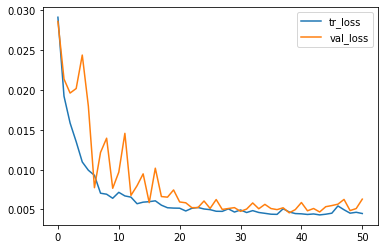

In [ ]:

#sns.lineplot(data=df[['tr_iou','val_iou']], dashes=False)
sns.lineplot(data=df[['tr_loss','val_loss']], dashes=False)

ResNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet(3,1, [3,4,9]).to(device)
init_weights(model)
dataset = train(model,train_dataloader, val_dataloader, EPOCH=66, lr=0.01, momentum=0.9, checkpoint=5)
df = pd.DataFrame(dataset, columns = ['tr_loss','tr_iou','val_loss','val_iou'])
df.to_csv('results_RESNET_IOU2.csv')

  2%|▏         | 1/66 [09:09<9:54:56, 549.18s/it]

tr_loss:  0.0329 tr_iou :  0.0038 val_loss:  0.5408 val_iou :  0.0000


  9%|▉         | 6/66 [11:17<55:30, 55.51s/it]  

tr_loss:  0.0200 tr_iou :  0.0065 val_loss:  0.0207 val_iou :  0.0006


 17%|█▋        | 11/66 [13:24<27:36, 30.11s/it]

tr_loss:  0.0187 tr_iou :  0.4391 val_loss:  0.0286 val_iou :  0.2439


 24%|██▍       | 16/66 [15:32<21:55, 26.31s/it]

tr_loss:  0.0136 tr_iou :  0.5114 val_loss:  0.0133 val_iou :  0.6025


 32%|███▏      | 21/66 [17:40<19:15, 25.67s/it]

tr_loss:  0.0114 tr_iou :  0.5567 val_loss:  0.0166 val_iou :  0.5644


 39%|███▉      | 26/66 [19:48<17:02, 25.57s/it]

tr_loss:  0.0092 tr_iou :  0.6404 val_loss:  0.0120 val_iou :  0.6239


 47%|████▋     | 31/66 [21:55<14:54, 25.56s/it]

tr_loss:  0.0091 tr_iou :  0.6478 val_loss:  0.0106 val_iou :  0.6573


 55%|█████▍    | 36/66 [24:05<12:57, 25.93s/it]

tr_loss:  0.0091 tr_iou :  0.6616 val_loss:  0.0120 val_iou :  0.6678


 62%|██████▏   | 41/66 [26:13<10:40, 25.60s/it]

tr_loss:  0.0078 tr_iou :  0.6947 val_loss:  0.0091 val_iou :  0.6990


 70%|██████▉   | 46/66 [28:20<08:29, 25.45s/it]

tr_loss:  0.0106 tr_iou :  0.6225 val_loss:  0.0125 val_iou :  0.5856


 77%|███████▋  | 51/66 [30:27<06:22, 25.47s/it]

tr_loss:  0.0071 tr_iou :  0.7130 val_loss:  0.0094 val_iou :  0.7237


 85%|████████▍ | 56/66 [32:34<04:14, 25.45s/it]

tr_loss:  0.0064 tr_iou :  0.7450 val_loss:  0.0091 val_iou :  0.6506


 92%|█████████▏| 61/66 [34:41<02:06, 25.40s/it]

tr_loss:  0.0146 tr_iou :  0.5756 val_loss:  0.0151 val_iou :  0.5089


100%|██████████| 66/66 [36:48<00:00, 33.46s/it]

tr_loss:  0.0060 tr_iou :  0.7655 val_loss:  0.0111 val_iou :  0.6645


Pretrained UNet

In [ ]:

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [ ]:
model = model.to(device)
criterion = nn.BCELoss().to(device)
dataset = train(model,criterion,train_dataloader, val_dataloader, EPOCH=26, lr=0.01, momentum=0.9, checkpoint=5)
test(model, criterion, test_dataloader)
df = pd.DataFrame(dataset, columns = ['tr_loss','tr_iou','val_loss','val_iou'])
df.to_csv(root_dir+'results/results_PRETRAINED_UNET_32_256_IOU.csv')
torch.save(model, root_dir+'Models/results_PRETRAINED_UNET_32_256_IOU')

  4%|▍         | 1/26 [00:11<04:51, 11.64s/it]

tr_loss:  0.0297 tr_iou :  0.4035 val_loss:  0.0260 val_iou :  0.3537


 23%|██▎       | 6/26 [01:07<03:42, 11.12s/it]

tr_loss:  0.0074 tr_iou :  0.7168 val_loss:  0.0071 val_iou :  0.7574


 42%|████▏     | 11/26 [02:03<02:50, 11.39s/it]

tr_loss:  0.0065 tr_iou :  0.7447 val_loss:  0.0081 val_iou :  0.6994


 62%|██████▏   | 16/26 [02:59<01:51, 11.20s/it]

tr_loss:  0.0056 tr_iou :  0.7703 val_loss:  0.0102 val_iou :  0.6246


 73%|███████▎  | 19/26 [03:32<01:18, 11.16s/it]

Pretrained ResNet

In [ ]:
model = ResNetUpdated(3,1,  models.resnet34(pretrained = True)).to(device)
criterion = nn.BCELoss().to(device)
dataset = train(model,criterion,train_dataloader, val_dataloader, EPOCH=26, lr=0.01, momentum=0.9, checkpoint=5)
test(model, criterion, test_dataloader)
df = pd.DataFrame(dataset, columns = ['tr_loss','tr_iou','val_loss','val_iou'])
df.to_csv(root_dir+'results/results_PRETRAINED_UNET_RESNET34_IOU.csv')
torch.save(model, root_dir+'Models/results_PRETRAINED_RESNET34_IOU')

  4%|▍         | 1/26 [00:25<10:35, 25.43s/it]

tr_loss:  0.0334 tr_iou :  0.0050 val_loss:  0.0303 val_iou :  0.0000


 23%|██▎       | 6/26 [02:23<07:52, 23.60s/it]

tr_loss:  0.0197 tr_iou :  0.1722 val_loss:  0.0300 val_iou :  0.1298


 42%|████▏     | 11/26 [04:20<05:52, 23.53s/it]

tr_loss:  0.0146 tr_iou :  0.3935 val_loss:  0.0168 val_iou :  0.4966


 62%|██████▏   | 16/26 [06:18<03:55, 23.53s/it]

tr_loss:  0.0117 tr_iou :  0.5109 val_loss:  0.0146 val_iou :  0.4889


 81%|████████  | 21/26 [08:15<01:57, 23.52s/it]

tr_loss:  0.0111 tr_iou :  0.5314 val_loss:  0.0135 val_iou :  0.5635


100%|██████████| 26/26 [10:13<00:00, 23.59s/it]

tr_loss:  0.0100 tr_iou :  0.5947 val_loss:  0.0126 val_iou :  0.5814


test_loss:  0.0120 test_iou :  0.4626
